In [1]:
!pip install datasets
!pip install transformers==4.28.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mean: 62.97115384615385


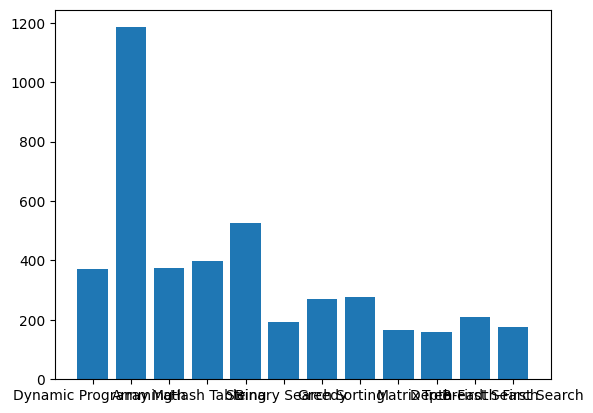

In [2]:
from transformers.models.detr.image_processing_detr import defaultdict
from google.colab import drive
import json
import datasets
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

drive.mount('/content/drive')

with open("/content/drive/MyDrive/data.json", "r") as data_json:
    algorithmDict = json.load(data_json)


cntDict = defaultdict(int)

for text in algorithmDict:
    for label in algorithmDict[text]:
        cntDict[label] += 1

s = 0
for label in cntDict:
    #print(label, cntDict[label])
    s += cntDict[label]
print("mean:", s/len(cntDict))

x = []
values = []
ticks = []

labels = []
i = 0
for label in cntDict:
    if cntDict[label] > 150:
        labels.append(label)
        x.append(i)
        i+=1
        values.append(cntDict[label])
        ticks.append(label)

plt.bar(x, values)
plt.xticks(x, ticks)
plt.show()

id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [3]:
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import random

tokenizer = AutoTokenizer.from_pretrained("yikuan8/Clinical-Longformer")
unmasker = pipeline('fill-mask', model='yikuan8/Clinical-Longformer')#'bert-base-cased')

def random_insert(input_text):
    input_text_list = input_text.split()
    len_input = len(input_text_list)
    rand_idx = random.randint(1,len_input-2)

    new_text_list = input_text_list[:rand_idx] + [tokenizer.mask_token] + orig_text_list[rand_idx:]
    new_mask_sent = ' '.join(new_text_list)

    augmented_text_list = unmasker(new_mask_sent)
    augmented_text = augmented_text_list[0]['sequence']
    return augmented_text

def random_replace(input_text):
    input_text_list = input_text.split()
    len_input = len(input_text_list)
    
    rand_idx = random.randint(1,len_input-1)
    orig_word = input_text_list[rand_idx]
    new_text_list = input_text_list.copy()
    new_text_list[rand_idx] = tokenizer.mask_token
    new_mask_sent = ' '.join(new_text_list)

    augmented_text_list = unmasker(new_mask_sent)
    for res in augmented_text_list:
        if res['token_str'] != orig_word:
            augmented_text = res['sequence']
            break
    return augmented_text

Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerForMaskedLM: ['longformer.embeddings.position_ids']
- This IS expected if you are initializing LongformerForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
'''
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

def summarize(title, problem):
    if len((title+' '+problem).split()) > 500:
        summary = summarizer(text, max_length=500-len(title.split()), min_length=10, do_sample=False)
        print(len(summary[0]["summary_text"].split()))
        return summary[0]["summary_text"]
    else:
        return problem
'''

dataDict = {}
pid = 1
weird = []

for full in algorithmDict:
    n = full.find('.')
    i = full.find('\n')
    title = full[n+2:i]
    print(pid, title)
    pid += 1
    problem = full[i+1:]
    if len(problem.split()) < 5:
        weird.append(title)
        continue
    dataDict[title + '\n' + problem] = algorithmDict[full]
    #dataDict[title + '\n' + random_replace(problem)] = algorithmDict[full]
print(weird)

1 Stone Game III
2 Two Sum
3 Add Two Numbers
4 Longest Substring Without Repeating Characters
5 Median of Two Sorted Arrays
6 Longest Palindromic Substring
7 Zigzag Conversion
8 Reverse Integer
9 String to Integer (atoi)
10 Palindrome Number
11 Regular Expression Matching
12 Container With Most Water
13 Integer to Roman
14 Roman to Integer
15 Longest Common Prefix
16 3Sum
17 3Sum Closest
18 Letter Combinations of a Phone Number
19 4Sum
20 Remove Nth Node From End of List
21 Valid Parentheses
22 Merge Two Sorted Lists
23 Generate Parentheses
24 Merge k Sorted Lists
25 Swap Nodes in Pairs
26 Reverse Nodes in k-Group
27 Remove Duplicates from Sorted Array
28 Remove Element
29 Find the Index of the First Occurrence in a String
30 Divide Two Integers
31 Substring with Concatenation of All Words
32 Next Permutation
33 Longest Valid Parentheses
34 Search in Rotated Sorted Array
35 Find First and Last Position of Element in Sorted Array
36 Search Insert Position
37 Valid Sudoku
38 Sudoku Solve

In [5]:
dataset = []

for text in dataDict:
    dic = {}
    dic['text'] = text
    chk = False
    for l in labels:
        dic[l] = l in dataDict[text]
        if dic[l]: chk = True
    if chk:
        dataset.append(dic.copy())

trn = int(len(dataset) * 0.8)
val = int(len(dataset) * 0.9)

train_dataset = dataset[:trn]
val_dataset = dataset[trn:val]
test_dataset = dataset[val:]

train_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=train_dataset))
val_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=val_dataset))
test_dataset = datasets.Dataset.from_pandas(pd.DataFrame(data=test_dataset))

dataset = datasets.DatasetDict({"train":train_dataset, "validation":val_dataset, "test":test_dataset})

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'Dynamic Programming', 'Array', 'Math', 'Hash Table', 'String', 'Binary Search', 'Greedy', 'Sorting', 'Matrix', 'Tree', 'Depth-First Search', 'Breadth-First Search'],
        num_rows: 1600
    })
    validation: Dataset({
        features: ['text', 'Dynamic Programming', 'Array', 'Math', 'Hash Table', 'String', 'Binary Search', 'Greedy', 'Sorting', 'Matrix', 'Tree', 'Depth-First Search', 'Breadth-First Search'],
        num_rows: 200
    })
    test: Dataset({
        features: ['text', 'Dynamic Programming', 'Array', 'Math', 'Hash Table', 'String', 'Binary Search', 'Greedy', 'Sorting', 'Matrix', 'Tree', 'Depth-First Search', 'Breadth-First Search'],
        num_rows: 201
    })
})

In [6]:
from transformers import AutoTokenizer, LongformerTokenizerFast
import numpy as np

tokenizer = LongformerTokenizerFast.from_pretrained('yikuan8/Clinical-Longformer', max_length = 1024)

def preprocess_data(examples):
  text = examples["text"]
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=512)
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  labels_matrix = np.zeros((len(text), len(labels)))
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]
  encoding["labels"] = labels_matrix.tolist()
  return encoding

In [7]:
encoded_dataset = dataset.map(preprocess_data, batched=True, remove_columns=dataset['train'].column_names)
encoded_dataset.set_format("torch")

max_len = 0
for i in encoded_dataset['train']:
    max_len = max(max_len, len(i['input_ids']))
print(max_len)

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

512


In [8]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("yikuan8/Clinical-Longformer", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at yikuan8/Clinical-Longformer were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'longformer.embeddings.position_ids', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at yikuan8/Clinical-Longformer and are newly initial

In [9]:
batch_size = 1
metric_name = "f1"


In [10]:
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    logging_steps=1
)


In [11]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result


In [12]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


In [13]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a LongformerTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
trainer.save_model("/content/drive/MyDrive/")

In [ ]:
trainer.evaluate()
trainer.evaluate(encoded_dataset["test"])

In [ ]:
text = "1. Two Sum\nGiven an array of integers nums and an integer target, return indices of the two numbers such that they add up to target. nums target indices of the two numbers such that they add up to target target You may assume that each input would have exactly one solution, and you may not use the same element twice. exactly one solution exactly same You can return the answer in any order."

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)

logits = outputs.logits
logits.shape

# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)